# Segmentação de Clientes (Mall Customers) — Projeto Completo

Este notebook implementa um **projeto ponta-a-ponta de segmentação de clientes** para apoiar estratégias de **marketing, relacionamento e ofertas personalizadas**.

## Objetivos
- Explorar e entender o comportamento dos clientes.
- Preparar os dados (tratamento, codificação e padronização).
- Aplicar técnicas de **clusterização** (K-Means) e selecionar um número adequado de segmentos.
- Interpretar os clusters e propor **ações de negócio** por segmento.

> Base: `Mall_Customers.csv` (clientes de um shopping)  
> Variáveis típicas: idade, renda anual e “spending score” (propensão/nível de gastos).


In [11]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuração opcional de visualização
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True

DATA_PATH = r"G:\Meu Drive\Programação\Ciencia de dados\Modelos avançados\Duelo entre modelos. Radom forest x arvore de decisao\Mall_Customers.csv"


## 1) Carregamento dos dados

In [12]:
df = pd.read_csv(DATA_PATH)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [14]:
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
Spending Score (1-100),200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


## 2) Entendimento e saneamento rápido

- Vamos checar valores ausentes.
- Ajustar nomes de colunas para facilitar o uso.


In [15]:
df.isna().sum()


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [16]:
# Padronizando nomes de colunas
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income_k',
    'Spending Score (1-100)': 'spending_score'
})

df.head()


,customer_id,gender,age,annual_income_k,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 3) Análise Exploratória (EDA)

A ideia aqui é enxergar:
- Distribuições (idade, renda, spending score)
- Relações (ex.: renda vs spending score)
- Possíveis grupos naturais


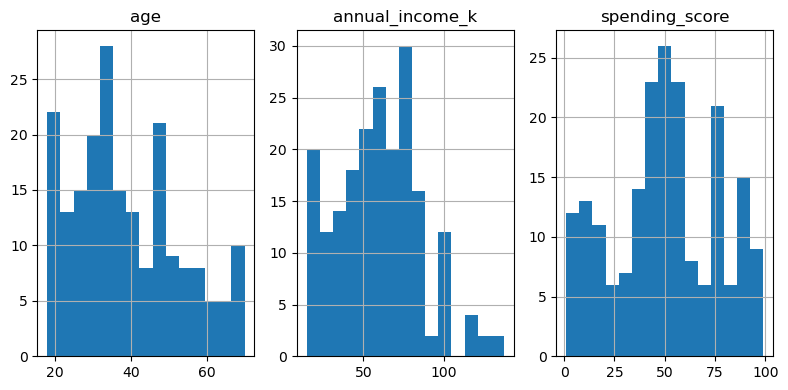

In [17]:
num_cols = ['age', 'annual_income_k', 'spending_score']

fig, axes = plt.subplots(1, 3)
for ax, col in zip(axes, num_cols):
    ax.hist(df[col], bins=15)
    ax.set_title(col)
plt.tight_layout()
plt.show()


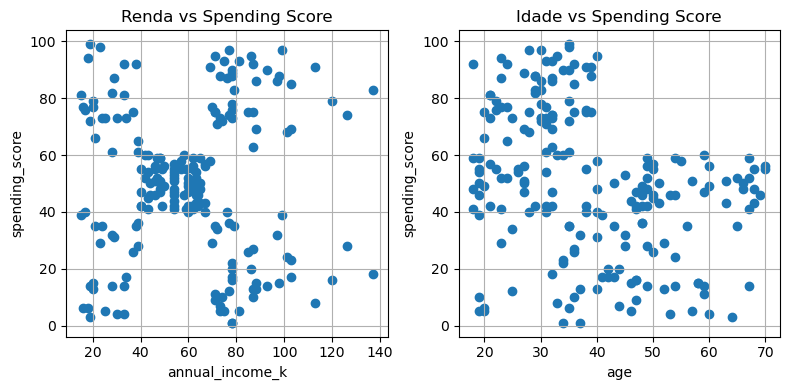

In [18]:
# Dispersões básicas
fig, axes = plt.subplots(1, 2)

axes[0].scatter(df['annual_income_k'], df['spending_score'])
axes[0].set_xlabel('annual_income_k')
axes[0].set_ylabel('spending_score')
axes[0].set_title('Renda vs Spending Score')

axes[1].scatter(df['age'], df['spending_score'])
axes[1].set_xlabel('age')
axes[1].set_ylabel('spending_score')
axes[1].set_title('Idade vs Spending Score')

plt.tight_layout()
plt.show()


## 4) Preparação para clusterização




In [19]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['gender']
numeric_features = ['age', 'annual_income_k', 'spending_score']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
    ],
    remainder='drop'
)

# Conferindo a transformação (forma final)
X = preprocess.fit_transform(df)
X.shape


(200, 4)

## 5) Escolha do número de clusters (k)

Vamos usar duas heurísticas comuns:
- **Elbow (inércia)**: procura um “cotovelo” onde o ganho marginal diminui.
- **Silhouette Score**: mede coesão/separação (quanto maior, melhor).  
  Observação: silhouette pode preferir k menor; usamos como guia, não regra.


c:\Users\jvmar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jvmar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\jvmar\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jvmar\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^

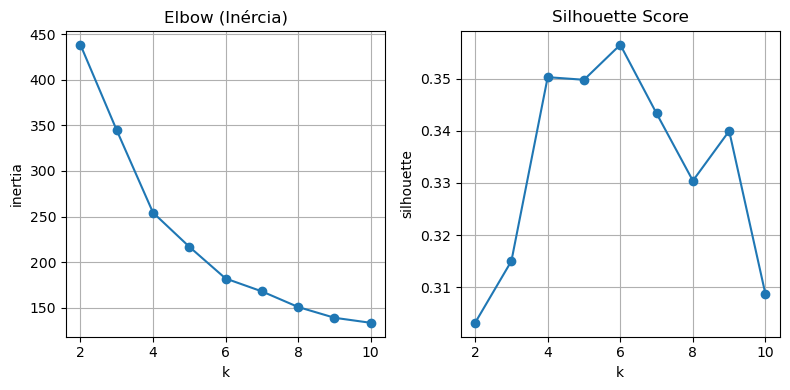

,k,inertia,silhouette
0,2,438.522412,0.303198
1,3,344.684940,0.315035
2,4,254.282907,0.350270
3,5,216.784902,0.349771
4,6,181.951436,0.356486
5,7,167.821344,0.343310
6,8,150.664747,0.330422
7,9,138.862796,0.339961
8,10,133.326640,0.308663


In [20]:
ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    inertias.append(model.inertia_)
    sil_scores.append(silhouette_score(X, model.labels_))

# Plotando
fig, axes = plt.subplots(1, 2)

axes[0].plot(list(ks), inertias, marker='o')
axes[0].set_title('Elbow (Inércia)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('inertia')

axes[1].plot(list(ks), sil_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('k')
axes[1].set_ylabel('silhouette')

plt.tight_layout()
plt.show()

pd.DataFrame({'k': list(ks), 'inertia': inertias, 'silhouette': sil_scores})


### Definição prática do k

A escolha final deve equilibrar:
- **Qualidade estatística** (silhouette / elbow)
- **Utilidade para negócio** (segmentos acionáveis: nem muitos, nem poucos)

Abaixo, definimos um `k_escolhido`.  



In [21]:
k_escolhido = 5
k_escolhido


5

## 6) Treinamento final do K-Means e rotulagem dos clientes

In [22]:
kmeans = KMeans(n_clusters=k_escolhido, random_state=42, n_init=20)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', kmeans)
])

df['cluster'] = pipe.fit_predict(df)

df.head()


c:\Users\jvmar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,customer_id,gender,age,annual_income_k,spending_score,cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,4
2,3,Female,20,16,6,2
3,4,Female,23,16,77,4
4,5,Female,31,17,40,2


In [23]:
df['cluster'].value_counts().sort_index()


cluster
0    58
1    39
2    47
3    34
4    22
Name: count, dtype: int64

## 7) Visualização em 2D (PCA)

Usamos PCA para projetar os dados (padronizados) em 2 dimensões e visualizar a separação dos clusters.


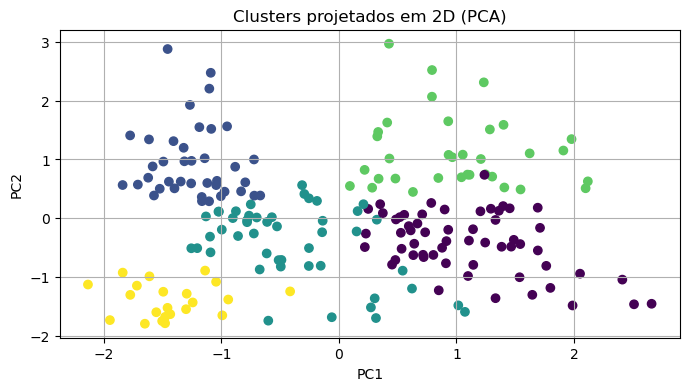

np.float64(0.7176959022847651)

In [24]:
X_scaled = preprocess.fit_transform(df.drop(columns=['cluster']))

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=df['cluster'])
plt.title('Clusters projetados em 2D (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

pca.explained_variance_ratio_.sum()


## 8) Perfil dos clusters (interpretação)

Vamos criar um “perfil” por cluster usando:
- Tamanho do segmento
- Médias e medianas das variáveis numéricas
- Distribuição de gênero


In [25]:
profile = (df
    .groupby('cluster')
    .agg(
        n=('customer_id', 'count'),
        age_mean=('age', 'mean'),
        income_mean=('annual_income_k', 'mean'),
        spend_mean=('spending_score', 'mean'),
        age_median=('age', 'median'),
        income_median=('annual_income_k', 'median'),
        spend_median=('spending_score', 'median'),
    )
    .sort_values('n', ascending=False)
)

profile


,n,age_mean,income_mean,spend_mean,age_median,income_median,spend_median
cluster,,,,,,,
0,58,55.551724,48.482759,41.775862,53.5,49.0,46.0
2,47,27.957447,50.000000,44.638298,27.0,54.0,47.0
1,39,32.692308,86.538462,82.128205,32.0,79.0,83.0
3,34,41.264706,88.500000,16.764706,42.5,85.5,15.5
4,22,25.272727,25.727273,79.363636,23.5,24.5,77.0


In [26]:
# % de gênero por cluster
gender_pct = (pd.crosstab(df['cluster'], df['gender'], normalize='index') * 100).round(1)
gender_pct


gender,Female,Male
cluster,,
0,56.9,43.1
1,53.8,46.2
2,66.0,34.0
3,41.2,58.8
4,59.1,40.9


### Visualizando as médias por cluster

Um gráfico simples ajuda a comparar rapidamente os segmentos.


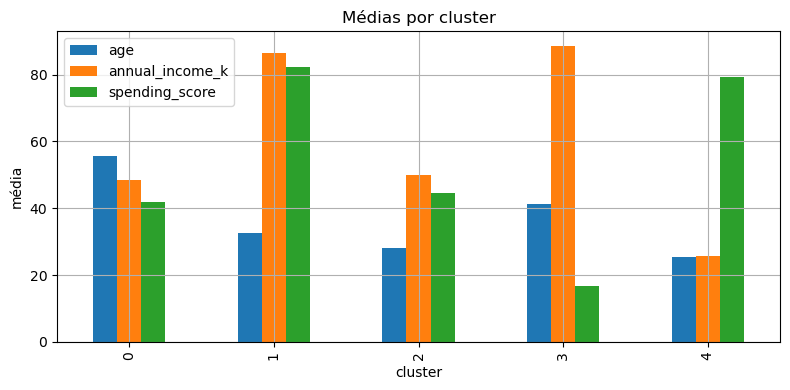

In [27]:
means = df.groupby('cluster')[['age', 'annual_income_k', 'spending_score']].mean()

means.plot(kind='bar')
plt.title('Médias por cluster')
plt.xlabel('cluster')
plt.ylabel('média')
plt.tight_layout()
plt.show()


## 9) Segmentos acionáveis: sugestões de estratégia

A seguir, vamos gerar uma interpretação automática **com base nas médias**.




In [28]:
# Criando rótulos heurísticos simples
seg = profile.copy()

def nivel(x, q33, q66):
    if x <= q33:
        return 'baixo'
    if x <= q66:
        return 'médio'
    return 'alto'

q_income_33, q_income_66 = df['annual_income_k'].quantile([0.33, 0.66]).tolist()
q_spend_33, q_spend_66 = df['spending_score'].quantile([0.33, 0.66]).tolist()
q_age_33, q_age_66 = df['age'].quantile([0.33, 0.66]).tolist()

labels = []
for cl in seg.index:
    inc = seg.loc[cl, 'income_mean']
    sp = seg.loc[cl, 'spend_mean']
    ag = seg.loc[cl, 'age_mean']
    label = f"renda {nivel(inc, q_income_33, q_income_66)} | gasto {nivel(sp, q_spend_33, q_spend_66)} | idade {nivel(ag, q_age_33, q_age_66)}"
    labels.append(label)

seg['label_heuristico'] = labels
seg[['n', 'age_mean', 'income_mean', 'spend_mean', 'label_heuristico']]


,n,age_mean,income_mean,spend_mean,label_heuristico
cluster,,,,,
0,58,55.551724,48.482759,41.775862,renda médio | gasto médio | idade alto
2,47,27.957447,50.000000,44.638298,renda médio | gasto médio | idade baixo
1,39,32.692308,86.538462,82.128205,renda alto | gasto alto | idade médio
3,34,41.264706,88.500000,16.764706,renda alto | gasto baixo | idade médio
4,22,25.272727,25.727273,79.363636,renda baixo | gasto alto | idade baixo


### Recomendações (guia prático)

Use o `label_heuristico` + os valores médios para definir ações como:

- **Alto gasto + alta renda**: VIP / fidelização, lançamentos, atendimento premium, upsell.
- **Alto gasto + baixa/média renda**: promoções inteligentes, combos, parcelamento, ofertas de valor.
- **Baixo gasto + alta renda**: ativação com experiências, cross-sell, provar novos produtos.
- **Baixo gasto + baixa renda**: ofertas de entrada, campanhas de reativação de baixo custo.
- **Clusters mais jovens**: canais digitais, gamificação, influenciadores.
- **Clusters mais maduros**: relacionamento, conveniência, atendimento e confiança.

Abaixo, vamos anexar um rótulo final ao dataframe e exportar para uso em campanhas.


In [38]:
# Criando um dicionário cluster -> label
cluster_to_label = seg['label_heuristico'].to_dict()

df['segmento'] = df['cluster'].map(cluster_to_label)

df[['customer_id', 'gender', 'age', 'annual_income_k', 'spending_score', 'cluster', 'segmento']].head(10)


,customer_id,gender,age,annual_income_k,spending_score,cluster,segmento
0,1,Male,19,15,39,2,renda médio | gasto médio | idade baixo
1,2,Male,21,15,81,4,renda baixo | gasto alto | idade baixo
2,3,Female,20,16,6,2,renda médio | gasto médio | idade baixo
3,4,Female,23,16,77,4,renda baixo | gasto alto | idade baixo
4,5,Female,31,17,40,2,renda médio | gasto médio | idade baixo
5,6,Female,22,17,76,4,renda baixo | gasto alto | idade baixo
6,7,Female,35,18,6,2,renda médio | gasto médio | idade baixo
7,8,Female,23,18,94,4,renda baixo | gasto alto | idade baixo
8,9,Male,64,19,3,0,renda médio | gasto médio | idade alto
9,10,Female,30,19,72,4,renda baixo | gasto alto | idade baixo


In [37]:
# Salvando um CSV com os segmentos (para ativação no marketing / CRM)
out_path = 'G:\\Meu Drive\\Programação\\Ciencia de dados\\Modelos avançados\\Duelo entre modelos. Radom forest x arvore de decisao\\Mall_Customers_segmented.csv'
df.to_csv(out_path, index=False)
out_path


'G:\\Meu Drive\\Programação\\Ciencia de dados\\Modelos avançados\\Duelo entre modelos. Radom forest x arvore de decisao\\Mall_Customers_segmented.csv'